##### Importing required libraries

In [5]:
from collections import Counter
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import numpy
from sklearn.utils import class_weight
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score

In [1]:
df = pd.read_parquet("/kaggle/input/acled-pq/africa_crime_cleaned.parquet")
df.head()

,INTERACTION,ADMIN1_encode,LOCATION_encode,ACTOR1_encode,DISORDER_TYPE_Demonstrations,DISORDER_TYPE_Political violence,DISORDER_TYPE_Political violence; Demonstrations,DISORDER_TYPE_Strategic developments,REGION_Eastern Africa,REGION_Middle Africa,...,INTER2_2,INTER2_3,INTER2_4,INTER2_5,INTER2_6,INTER2_7,INTER2_8,fatalites-binned,FATALITIES,fatalites-binned_label_encoded
0,27,807,8778,1367,0,1,0,0,0,0,...,0,0,0,0,0,1,0,2_TO_10,5,3
1,27,684,12445,1367,0,1,0,0,0,0,...,0,0,0,0,0,1,0,2_TO_10,2,3
2,27,706,12451,1367,0,1,0,0,0,0,...,0,0,0,0,0,1,0,2_TO_10,2,3
3,27,99,4705,1367,0,1,0,0,0,0,...,0,0,0,0,0,1,0,11_TO_50,16,1
4,27,807,8778,1367,0,1,0,0,0,0,...,0,0,0,0,0,1,0,11_TO_50,18,1


##### Dropping the "Fatalities" & "fatalites-binned" features

In [2]:
df = df.drop(["FATALITIES","fatalites-binned"], axis=1)
df.head().T

,0,1,2,3,4
INTERACTION,27,27,27,27,27
ADMIN1_encode,807,684,706,99,807
LOCATION_encode,8778,12445,12451,4705,8778
ACTOR1_encode,1367,1367,1367,1367,1367
DISORDER_TYPE_Demonstrations,0,0,0,0,0
...,...,...,...,...,...
INTER2_5,0,0,0,0,0
INTER2_6,0,0,0,0,0
INTER2_7,1,1,1,1,1
INTER2_8,0,0,0,0,0


##### Renaming the target variable to "FATALITIES"

In [3]:
df = df.rename(columns= {"fatalites-binned_label_encoded": "FATALITIES"})
df.head().T

,0,1,2,3,4
INTERACTION,27,27,27,27,27
ADMIN1_encode,807,684,706,99,807
LOCATION_encode,8778,12445,12451,4705,8778
ACTOR1_encode,1367,1367,1367,1367,1367
DISORDER_TYPE_Demonstrations,0,0,0,0,0
...,...,...,...,...,...
INTER2_5,0,0,0,0,0
INTER2_6,0,0,0,0,0
INTER2_7,1,1,1,1,1
INTER2_8,0,0,0,0,0


##### Inspecting the columns

In [4]:
df.columns

Index(['INTERACTION', 'ADMIN1_encode', 'LOCATION_encode', 'ACTOR1_encode',
       'DISORDER_TYPE_Demonstrations', 'DISORDER_TYPE_Political violence',
       'DISORDER_TYPE_Political violence; Demonstrations',
       'DISORDER_TYPE_Strategic developments', 'REGION_Eastern Africa',
       'REGION_Middle Africa',
       ...
       'INTER2_0', 'INTER2_1', 'INTER2_2', 'INTER2_3', 'INTER2_4', 'INTER2_5',
       'INTER2_6', 'INTER2_7', 'INTER2_8', 'FATALITIES'],
      dtype='object', length=119)

##### Splitting the data into training and testing set using stratified shuffle split

In [9]:
# Train-Test Split --> stratified
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["FATALITIES"]):
    train = df.loc[train_index]
    test = df.loc[test_index]

In [10]:
X_train = train.drop("FATALITIES", axis=1)
y_train = train["FATALITIES"]

X_test = test.drop("FATALITIES", axis=1)
y_test = test["FATALITIES"]

##### Summarize distribution

In [23]:
from collections import Counter

counter = Counter(y)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=3, n=48311 (15.291%)
Class=1, n=10242 (3.242%)
Class=2, n=39643 (12.548%)
Class=6, n=215810 (68.307%)
Class=5, n=1130 (0.358%)
Class=0, n=580 (0.184%)
Class=4, n=224 (0.071%)


In [24]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)

##### Oversampling and Undersampling on the Training data

In [9]:
# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
 per = v / len(y_train) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=6, n=151067 (68.307%)
Class=3, n=33818 (15.291%)
Class=2, n=27750 (12.548%)
Class=1, n=7169 (3.242%)
Class=0, n=406 (0.184%)
Class=5, n=791 (0.358%)
Class=4, n=157 (0.071%)


In [10]:
#4.1. Oversampling (SMOTE: Synthetic Minority Oversampling Technique)

from imblearn.over_sampling import SMOTE
strategy = {0:50000, 1:50000, 2:50000, 3:50000, 4:50000, 5:50000}
oversample = SMOTE(sampling_strategy=strategy, k_neighbors=7, random_state=42)

x_over, y_over = oversample.fit_resample(x_train, y_train)
print(Counter(y_over))

Counter({6: 151067, 3: 50000, 2: 50000, 1: 50000, 0: 50000, 5: 50000, 4: 50000})


In [11]:
from imblearn.under_sampling import RandomUnderSampler

strategy = {0:50000, 1:50000, 2:50000, 3:50000, 4:50000, 5:50000, 6:50000}

undersample = RandomUnderSampler(sampling_strategy=strategy)

x_final, y_final = undersample.fit_resample(x_over, y_over)
print(Counter(y_final))

Counter({0: 50000, 1: 50000, 2: 50000, 3: 50000, 4: 50000, 5: 50000, 6: 50000})


##### Undersampling and oversampling on test data

In [12]:
# summarize distribution
counter = Counter(y_test)
for k,v in counter.items():
 per = v / len(y_test) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=6, n=64743 (68.307%)
Class=3, n=14493 (15.291%)
Class=2, n=11893 (12.548%)
Class=1, n=3073 (3.242%)
Class=5, n=339 (0.358%)
Class=0, n=174 (0.184%)
Class=4, n=67 (0.071%)


In [13]:
#4.1. Oversampling (SMOTE: Synthetic Minority Oversampling Technique)

from imblearn.over_sampling import SMOTE
from collections import Counter

strategy = {0:10000, 1:10000, 4:10000, 5:10000}
oversample = SMOTE(sampling_strategy=strategy, k_neighbors=7, random_state=42)

x_tover, y_tover = oversample.fit_resample(x_test, y_test)
print(Counter(y_tover))

Counter({6: 64743, 3: 14493, 2: 11893, 1: 10000, 5: 10000, 0: 10000, 4: 10000})


In [14]:
from imblearn.under_sampling import RandomUnderSampler

strategy = {2:10000, 3:10000, 6:10000}

undersample = RandomUnderSampler(sampling_strategy=strategy)

x_test, y_test = undersample.fit_resample(x_tover, y_tover)
print(Counter(y_test))

Counter({0: 10000, 1: 10000, 2: 10000, 3: 10000, 4: 10000, 5: 10000, 6: 10000})


In [15]:
# summarize distribution
counter = Counter(y_test)
for k,v in counter.items():
 per = v / len(y_test) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=10000 (14.286%)
Class=1, n=10000 (14.286%)
Class=2, n=10000 (14.286%)
Class=3, n=10000 (14.286%)
Class=4, n=10000 (14.286%)
Class=5, n=10000 (14.286%)
Class=6, n=10000 (14.286%)


##### Data standardization and normalization

In [12]:
ss = StandardScaler()
ss_train = ss.fit_transform(X_train)
x_train_ss = pd.DataFrame(ss_train)
x_train_ss.columns=X_train.columns
x_train_ss.head()

#Test
ss_test = ss.fit_transform(X_test)
x_test_ss = pd.DataFrame(ss_test)
x_test_ss.columns=X_test.columns
x_test_ss.head()

,INTERACTION,ADMIN1_encode,LOCATION_encode,ACTOR1_encode,DISORDER_TYPE_Demonstrations,DISORDER_TYPE_Political violence,DISORDER_TYPE_Political violence; Demonstrations,DISORDER_TYPE_Strategic developments,REGION_Eastern Africa,REGION_Middle Africa,...,INTER1_8,INTER2_0,INTER2_1,INTER2_2,INTER2_3,INTER2_4,INTER2_5,INTER2_6,INTER2_7,INTER2_8
0,0.533373,-0.107962,0.950069,-1.155501,-0.642160,0.777384,-0.087857,-0.288945,-0.669232,-0.428157,...,-0.170205,-0.608096,-0.448911,-0.320077,-0.258782,4.983292,-0.119661,-0.064896,-0.705932,-0.131557
1,-1.115965,-0.700312,-1.120655,1.098990,-0.642160,0.777384,-0.087857,-0.288945,-0.669232,-0.428157,...,-0.170205,-0.608096,2.227612,-0.320077,-0.258782,-0.200671,-0.119661,-0.064896,-0.705932,-0.131557
2,1.384645,-1.331126,-1.252316,0.604069,1.557244,-1.286365,-0.087857,-0.288945,-0.669232,-0.428157,...,-0.170205,1.644477,-0.448911,-0.320077,-0.258782,-0.200671,-0.119661,-0.064896,-0.705932,-0.131557
3,1.384645,-1.054183,-1.021375,0.571940,1.557244,-1.286365,-0.087857,-0.288945,-0.669232,-0.428157,...,-0.170205,1.644477,-0.448911,-0.320077,-0.258782,-0.200671,-0.119661,-0.064896,-0.705932,-0.131557
4,1.384645,-0.688773,0.420678,0.599283,1.557244,-1.286365,-0.087857,-0.288945,-0.669232,-0.428157,...,-0.170205,1.644477,-0.448911,-0.320077,-0.258782,-0.200671,-0.119661,-0.064896,-0.705932,-0.131557


##### Combining the processed features with their corresponding target variable

In [13]:
df_train_processed = pd.concat([x_train_ss, y_train], axis=1) #combine processed features with their target

cm_a = df_train_processed.corr()

print(cm_a.FATALITIES.sort_values().tail(10))

COUNTRY_Gabon                0.003515
COUNTRY_Tanzania             0.003615
EVENT_TYPE_Protests          0.003783
COUNTRY_Rwanda               0.003867
COUNTRY_South Sudan          0.004112
SUB_EVENT_TYPE_Other         0.004727
COUNTRY_Somalia              0.004818
COUNTRY_Equatorial Guinea    0.005670
REGION_Eastern Africa        0.009362
FATALITIES                   1.000000
Name: FATALITIES, dtype: float64


##### Dimensionality Reduction (Component-based): PCA 
##### PCA groups variables by their correlations, and each group is condisidered as a factor
##### PCA creates a new set of variables with a smaller set of factors that are uncorrelated
##### In such a way that 1st PC explains maximum variance, followed by 2nd and so on (n_components)
##### Click [here](https://www.analyticsvidhya.com/blog/2021/07/svm-and-pca-tutorial-for-beginners/) for more on PCA

90


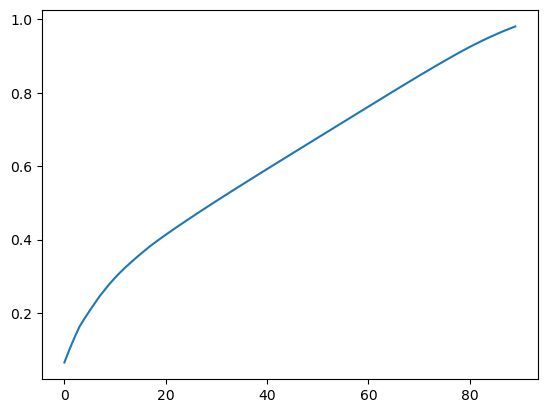

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,-2.708489,1.715228,-0.899590,-1.034446,1.212588,-1.722041,1.431880,0.174758,1.537130,-0.959241,...,-0.787407,0.077059,0.404893,0.570964,-0.488226,-0.713372,0.367994,0.677645,0.605396,0.273834
1,-1.074429,2.619110,0.534266,-0.903492,-0.277838,0.721408,1.165177,-0.540434,-0.154262,3.615684,...,-0.860545,0.918195,0.484583,0.693901,-1.361295,0.485190,-0.659998,0.152582,-0.501832,-0.796622
2,-2.064917,2.462031,-1.266834,0.036107,-0.528152,-1.492057,-2.611547,1.291034,1.992337,-0.190491,...,-0.279927,0.217764,-0.542226,0.233057,0.770597,-0.494367,-0.877287,-0.323302,0.195182,-0.402445
3,-1.487386,-1.262838,0.330809,-0.923344,-2.675681,-3.248172,-2.630899,0.527172,-2.307167,-0.101320,...,0.775998,0.184964,-0.415657,0.786318,-0.265554,-0.772020,-0.622556,0.920972,0.258727,-0.398354
4,2.163600,-1.422312,0.310296,-0.457873,0.596448,-0.591079,2.080207,2.233697,1.105713,-1.418057,...,0.364967,-0.520017,-0.610311,0.625375,0.964802,0.501855,-1.900322,-0.311474,0.382664,0.023144


In [14]:

df_train_processed.shape


pca = PCA(n_components=90)

pca_train = pca.fit(x_train_ss)
print(pca_train.n_components_)

plt.plot(np.cumsum(pca_train.explained_variance_ratio_))
plt.show()

x_train_ss_over_pca = pd.DataFrame(pca_train.transform(x_train_ss))
x_train_ss_over_pca.head()

##### Apply PCA on x_test set

In [15]:
x_test_ss_over_pca = pd.DataFrame(pca.transform(x_test_ss))
x_test_ss_over_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,-1.855278,-1.507052,0.086121,-0.813522,-2.767001,-3.321913,-2.696633,0.448834,-1.894194,-0.359251,...,0.875753,0.163973,-0.409815,0.777802,-0.410459,-0.257525,-0.119925,0.303349,-0.041461,-0.001984
1,-1.890254,-1.292914,0.598685,-0.091433,-1.191087,-1.130520,-1.816198,1.282070,0.674499,0.401465,...,-0.384104,0.457397,1.684252,-0.891236,0.798625,-0.917394,-0.671626,1.111492,-0.109055,-0.140015
2,5.150340,-0.850810,-1.347788,-1.033827,0.337481,0.218613,-0.259351,-0.614513,-0.290559,-1.248507,...,0.289483,-0.279838,0.665290,-1.144124,-0.346824,0.603591,-0.646478,0.873506,-0.311766,-1.421405
3,4.759463,-0.922277,-1.205179,-0.929735,0.706444,0.627625,-0.506533,-0.379939,-0.321726,-0.959466,...,0.261162,0.510295,-0.550440,0.248999,-0.324640,-0.789773,-0.093208,-0.094600,0.515860,0.116213
4,5.184439,0.178928,0.013466,-0.525107,-0.601410,-0.772143,1.413699,-0.957613,1.157274,3.099777,...,-0.448690,0.433409,0.167925,0.503358,-0.423091,-0.236058,-0.136218,0.398108,-0.056064,-0.684441


##### Instantiating the models to be used
##### Setting the class weights as balanced prompts the XGB classifier to handle the imbalanced data set in a none balanced way

In [16]:

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [17]:
%%time
model = XGBClassifier(
        base_score=0.5,
        booster='gbtree',
        colsample_bylevel=0.9,
        colsample_bynode=1,
        colsample_bytree=1,
        eta=0.05,
        gamma=0,
        gpu_id=-1,
        importance_type='gain',
        interaction_constraints='',
        learning_rate=0.0500000007,
        max_delta_step=0,
        max_depth=10,
        max_leaves=1023,
        min_child_weight=1,
        missing=numpy.nan,
        monotone_constraints='()',
        n_estimators=300,
        n_jobs=-1,
        num_parallel_tree=1,
        objective='multi:softprob',
        random_state=0,
        reg_alpha=0.625,
        reg_lambda=1.5625,
        scale_pos_weight=None,
        subsample=1,
        tree_method='auto',
        validate_parameters=1,
        verbose=-10,
        verbosity=0
    )
model.fit(x_train_ss_over_pca, y_train, sample_weight=classes_weights)
train_score = round(model.score(x_train_ss_over_pca, y_train),2)
test_score = round(model.score(x_test_ss_over_pca, y_test),2)
print(train_score)
print(test_score)

0.69
0.63
CPU times: user 5h 26min 24s, sys: 14.2 s, total: 5h 26min 38s
Wall time: 1h 23min 14s


In [44]:

def MLA_testing(MLA, x_train_ss_over_pca, x_test_ss_over_pca, y_train, y_test):      
    # Training The Model
    MLA.fit(x_train_ss_over_pca.values, y_train, sample_weight=classes_weights)

    # KFold Accuracies on Training Data
    kfold_accuracy = cross_val_score(estimator = MLA, X = x_train_ss_over_pca, y = y_train, cv = 10, n_jobs=-1)
    print("K-Fold Accuracies:\n", kfold_accuracy, "\n")
    
    # Prediction on Testing Data
    y_pred = cross_val_predict(estimator = MLA, X = x_test_ss_over_pca, y = y_test, cv = 10, n_jobs=-1)
    
    # Accuracy for y_test and y_pred
    classifier_accuracy_score = accuracy_score(y_test, y_pred)
    print("Accuracy Score:\n", classifier_accuracy_score, "\n")
    
    # Confusion Matrix
    conf_mtx = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_mtx, "\n")
    
    # Classification Report
    class_rep = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_rep, "\n")
    
    try:
        # Precision - Recall Curve
        yhat = MLA.predict_proba(x_test_ss_over_pca)
        precision, recall, _ = precision_recall_curve(y_test, yhat[:, 1])
        
        plt.figure(dpi=100, figsize=(15, 6))
        plt.subplot(121)
        sns.lineplot([0, 1], [1, 0], linestyle='--', label='No Skill')
        sns.lineplot(recall, precision, marker='.', label=MLA.__class__.__name__)
        plt.title("Recall vs Precision Curve")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        
        # ROC Curve
        plt.subplot(122)
        sns.lineplot([0, 1], [0, 1], linestyle='--', label='No Skill')
        fpr, tpr, _ = roc_curve(y_test, yhat[:, 1])
        sns.lineplot(fpr, tpr, marker='.', label=MLA.__class__.__name__)
        plt.title("ROC Curve")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        
        plt.show()
    except:
        pass
    
    # Important Features for The Algorithms
    imp_cols = pd.DataFrame()
    imp_cols["Features"] = x_train_ss_over_pca.columns
    imp_cols["Importance"] = MLA.feature_importances_
    imp_cols = imp_cols.sort_values(by="Importance", ascending=False)
    
    plt.figure(dpi=80, figsize=(10, 8))
    sns.barplot(y="Features", x="Importance", data=imp_cols)
    plt.title("Importance of Features")
    plt.show()

K-Fold Accuracies:
 [0.72038343 0.72101646 0.72088081 0.72228251 0.71907216 0.72042865
 0.72069995 0.71717309 0.7221343  0.71969252] 

Accuracy Score:
 0.7142811926315124 

Confusion Matrix:
 [[    0     5     8    44     1     0   116]
 [    0   120   170  1059     3     0  1721]
 [    0    23  3666  1892     0     0  6312]
 [    0   138  1855  4060     3     0  8437]
 [    0     0     0     5    30     0    32]
 [    0     9    19    96     0     0   215]
 [    0    50  2492  2359    17     0 59825]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       174
           1       0.35      0.04      0.07      3073
           2       0.45      0.31      0.36     11893
           3       0.43      0.28      0.34     14493
           4       0.56      0.45      0.50        67
           5       0.00      0.00      0.00       339
           6       0.78      0.92      0.85     64743

    accuracy                    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


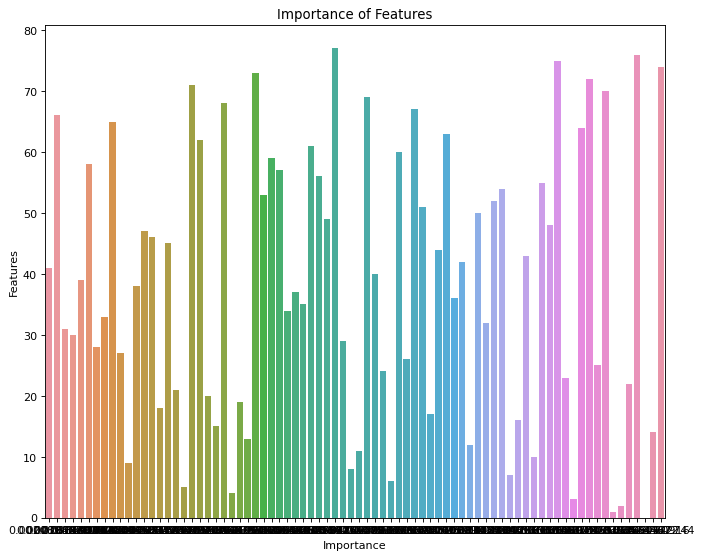

In [45]:

MLA_testing(model, x_train_ss_over_pca, x_test_ss_over_pca, y_train, y_test)

In [46]:
# Hypeparameter Tuning using RandomGrid
model.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 0.9,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.0500000007,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 10,
 'max_leaves': 1023,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 2,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0.625,
 'reg_lambda': 1.5625,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'auto',
 'validate_parameters': 1,
 'verbosity': 0,
 'eta': 0.05,
 'verbose': -10}

In [72]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels.
    """
    accuracy = accuracy_score(y_test, y_preds)
    precision = precision_score(y_test, y_preds, average="micro")
    recall = recall_score(y_test, y_preds, average="micro")
    f1 = f1_score(y_test, y_preds, average="micro")
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2), 
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return metric_dict

In [108]:
y_preds = model.predict(x_test_ss_over_pca)

rs_metrics = evaluate_preds(y_test, y_preds)

Acc: 61.87%
Precision: 0.62
Recall: 0.62
F1 score: 0.62
